# Melanoma Detection - CNN Assignment

## Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:
- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

Data can be downloaded from [here](https://drive.google.com/file/d/1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs/view).

## Pipeline Steps:

1. Data Reading/Data Understanding
2. Dataset Creation
3. Dataset Visualisation
4. Model Building & Training
5. Model Building & Training (on the augmented data)
6. Class Distribution
7. Handling Class Imbalances
8. Model Building & Training (on the rectified class imbalance data)

### Pre-requisites

_This notebook was run on python v3.10.8 and Apple M1 sillicon._

**NOTE: Please extract the dataset and set the correct data path.**

Installing the required libraries.

In [1]:
%pip install numpy~=1.24.3
%pip install matplotlib~=3.7.1
%pip install tensorflow~=2.13.0
%pip install Augmentor~=0.2.12

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Importing all the required libraries for the case study.

In [2]:
import os.path
import pathlib
import shutil

import Augmentor
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

Setting up the paths.

In [3]:
data_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration'

train_data_dir = pathlib.Path(os.path.join(data_dir, 'Train'))
test_data_dir = pathlib.Path(os.path.join(data_dir, 'Test'))

### 1. Data Reading/Data Understanding

In [4]:
train_img_count = len(list(train_data_dir.glob('*/*.jpg')))
test_img_count = len(list(test_data_dir.glob('*/*.jpg')))

print("Image count: ")
print(f"Train: {train_img_count}")
print(f"Test {test_img_count}")

Image count: 
Train: 2239
Test 118


### 2. Dataset Creation

Create 80/20 training and validation datasets from the train data with image size 180x180 and batch size 32.

In [5]:
img_width, img_height = 180, 180
batch_size = 32

In [6]:
train_ds, val_ds = keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [7]:
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### 3. Dataset Visualisation

#### 3.1. Classes Overview

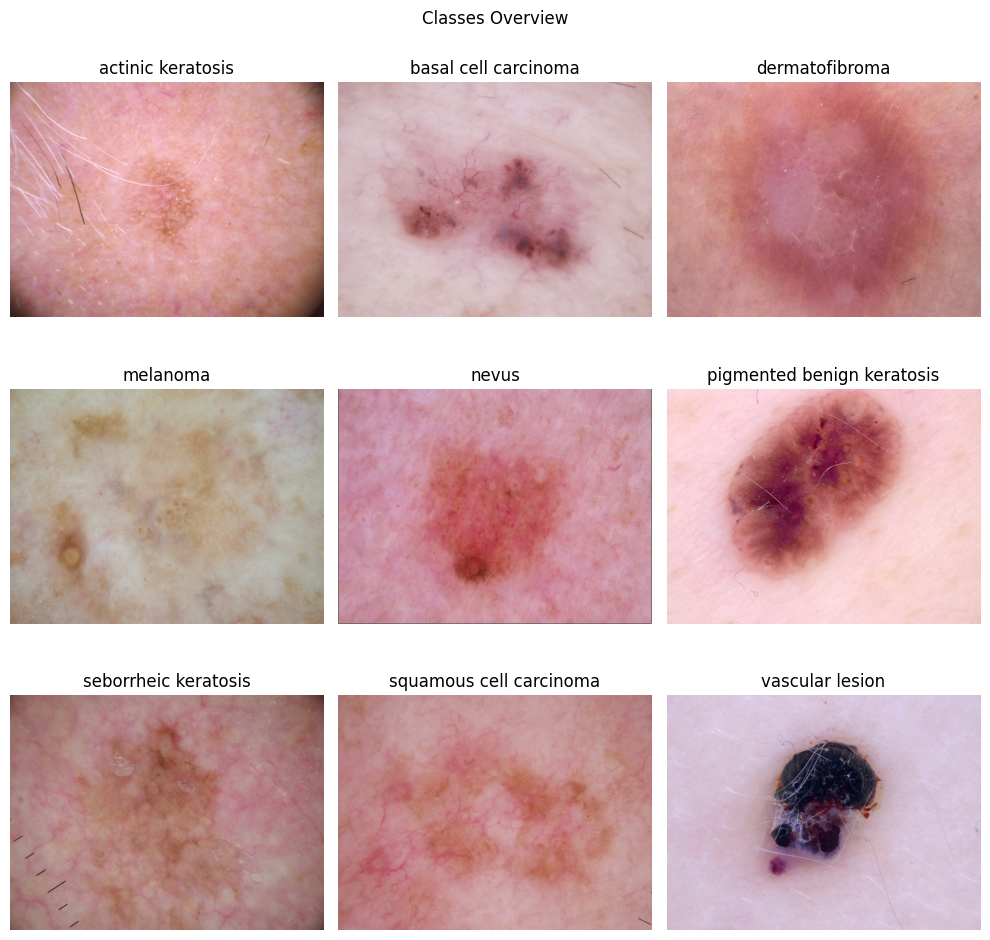

In [9]:
plt.figure(figsize=(10, 10))

for class_index, class_name in enumerate(class_names):
    image_path = list(train_data_dir.glob(class_name + '/*.jpg'))[0]
    image = plt.imread(str(image_path))

    plt.subplot(3, 3, class_index + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")

plt.suptitle('Classes Overview')
plt.tight_layout()
plt.show()

#### 3.2. Class Distribution

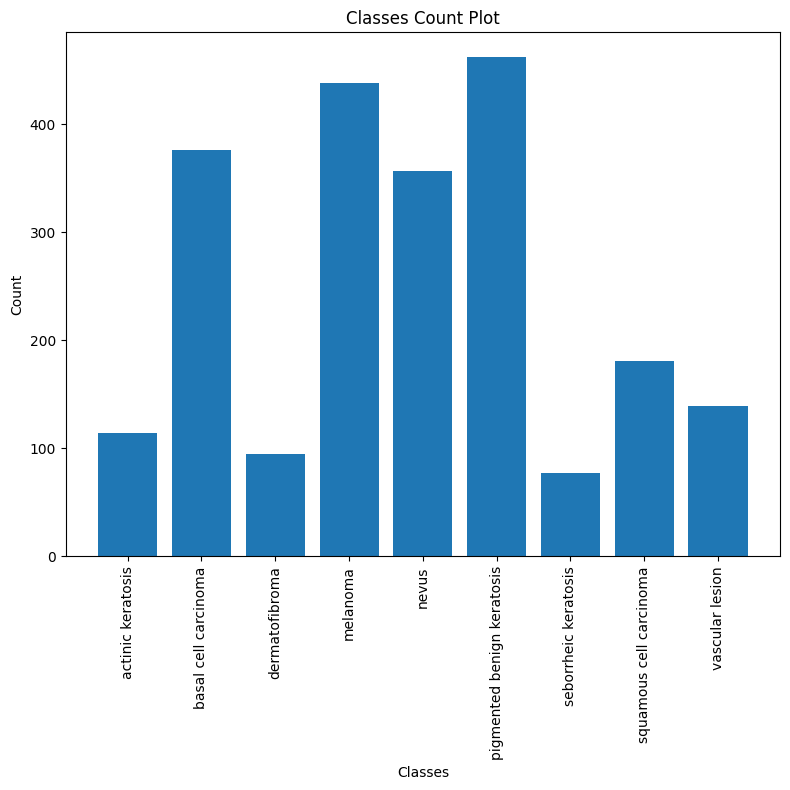

In [10]:
class_count = []

for i in class_names:
    class_count.append(len(list(train_data_dir.glob(i+'/*.jpg'))))

plt.figure(figsize=(8, 8))
plt.bar(class_names, class_count)

plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Classes Count Plot")

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

We do see that there are classes with lesser samples, and may require augmentation. 

### 4. Model Building & Training

#### 4.1. Model Creation

In [11]:
model_1 = keras.Sequential()

# Rescaling layer for rescaling the pixel values range to be in (0, 1)
model_1.add(keras.layers.Rescaling(scale=1./255, input_shape=(180, 180, 3)))

# First convolution layer with 64 features, 3x3 filter, relu activation with 2x2 pooling and batch normalization
model_1.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_1.add(keras.layers.MaxPooling2D())
model_1.add(keras.layers.BatchNormalization())

# Second convolution layer with 64 features, 3x3 filter, relu activation with 2x2 pooling and batch normalization
model_1.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_1.add(keras.layers.MaxPooling2D())
model_1.add(keras.layers.BatchNormalization())

# Third convolution layer with 128 features, 3x3 filter, relu activation with 2x2 pooling and 25% dropout
model_1.add(keras.layers.Conv2D(
    128, (3, 3), padding='same', activation='relu'))
model_1.add(keras.layers.MaxPooling2D())
model_1.add(keras.layers.Dropout(0.25))

# Fourth convolution layer with 128 features, 3x3 filter, relu activation with 2x2 pooling and 25% dropout
model_1.add(keras.layers.Conv2D(
    128, (3, 3), padding='same', activation='relu'))
model_1.add(keras.layers.MaxPooling2D())
model_1.add(keras.layers.Dropout(0.25))

# Final dense layer with relu and softmax activation and 50% dropout
model_1.add(keras.layers.Flatten())
model_1.add(keras.layers.Dense(256, activation='relu'))
model_1.add(keras.layers.Dropout(0.5))
model_1.add(keras.layers.Dense(9, activation='softmax'))

#### 4.2. Model Compiling

In [12]:
model_1.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 90, 90, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0

#### 4.3. Model Training

In [13]:
history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
56/56 [==============================] - 41s 647ms/step - loss: 1.9707 - accuracy: 0.3493 - val_loss: 2.1864 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 34s 612ms/step - loss: 1.5607 - accuracy: 0.4503 - val_loss: 2.1848 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 34s 615ms/step - loss: 1.4752 - accuracy: 0.4766 - val_loss: 2.1841 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 36s 645ms/step - loss: 1.3793 - accuracy: 0.5268 - val_loss: 2.2625 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 34s 614ms/step - loss: 1.3251 - accuracy: 0.5201 - val_loss: 2.1729 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 34s 612ms/step - loss: 1.2874 - accuracy: 0.5379 - val_loss: 2.1271 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 34s 606ms/step - loss: 1.2492 - accuracy: 0.5536 - val_loss: 2.0198 - val_accuracy: 0.2752

#### 4.4. Results

In [14]:
def plot_train_val(history, epochs: int) -> None:
    """
    Plot 'Training and Validation Accuracy' and 'Training and Validation Loss' curves.

        Args:
            history: Fitted CNN model history
            epochs: Number of epochs

        Returns:
            None
    """

    acc = history['accuracy']
    val_acc = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = np.arange(epochs)
    x_ticks = np.arange(epochs, step=2)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xticks(x_ticks)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xticks(x_ticks)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

    return None

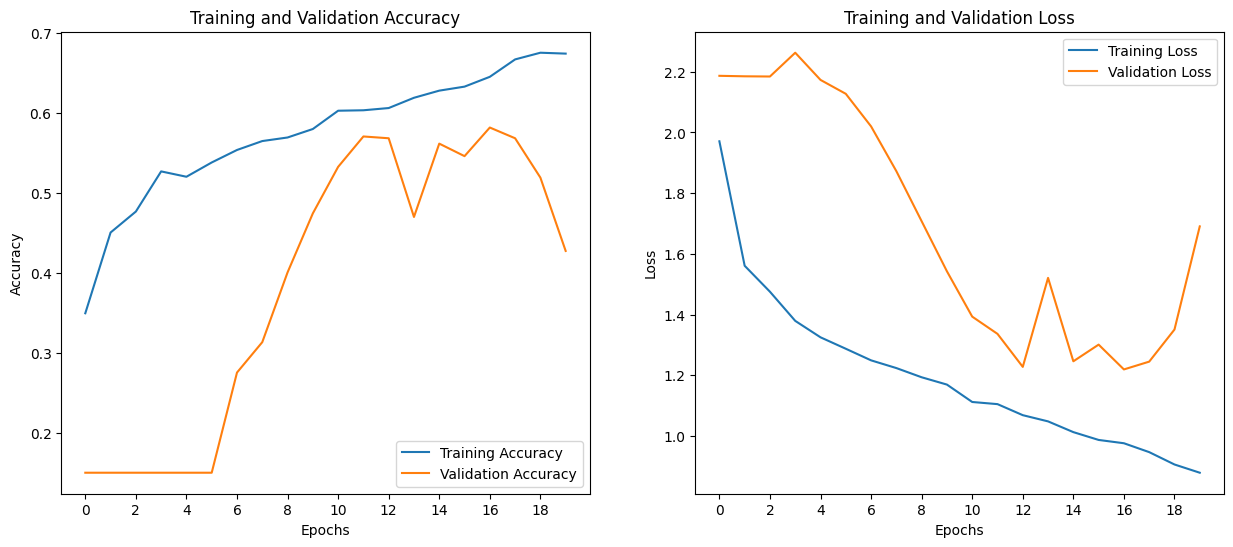

In [15]:
plot_train_val(history_1.history, 20)

From the plot above we can see that the model is underfitting, maybe adding more samples would help.

### 5. Model Building & Training (on the augmented data)

#### 5.1. Data Augmentation

Creating 500 more samples for each class. Using zoom, flip, rotate, skew, shear, and distort will help better as to prevent overfitting. 

In [16]:
augment_probability = .75

for class_name in class_names:
    p = Augmentor.Pipeline(os.path.join(train_data_dir, class_name))
    p.set_seed(42)
    
    p.zoom(probability=augment_probability, min_factor=1.1, max_factor=1.5)
    p.flip_random(probability=augment_probability)
    p.rotate(probability=augment_probability,
                max_left_rotation=10, max_right_rotation=10)
    p.skew(probability=augment_probability, magnitude=.5)
    p.shear(probability=augment_probability,
            max_shear_left=10, max_shear_right=10)
    p.random_distortion(probability=augment_probability,
                        grid_height=5, grid_width=5, magnitude=5)
    
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16A2190F0>: 100%|██████████| 500/500 [00:04<00:00, 101.61 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16A0FD870>: 100%|██████████| 500/500 [00:04<00:00, 102.56 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16A32BF10>: 100%|██████████| 500/500 [00:05<00:00, 97.81 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x118966020>: 100%|██████████| 500/500 [00:26<00:00, 19.05 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16A121F90>: 100%|██████████| 500/500 [00:26<00:00, 19.12 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16A298D60>: 100%|██████████| 500/500 [00:05<00:00, 96.71 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16A317CD0>: 100%|██████████| 500/500 [00:12<00:00, 39.05 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16A121F30>: 100%|██████████| 500/500 [00:05<00:00, 98.44 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16A317EB0>: 100%|██████████| 500/500 [00:05<00:00, 98.72 Samples/s] 


In [17]:
train_img_count = len(list(train_data_dir.glob('*/output/*.jpg')))
print(train_img_count)

4500


#### 5.2. Classes Overview (after augmentation)

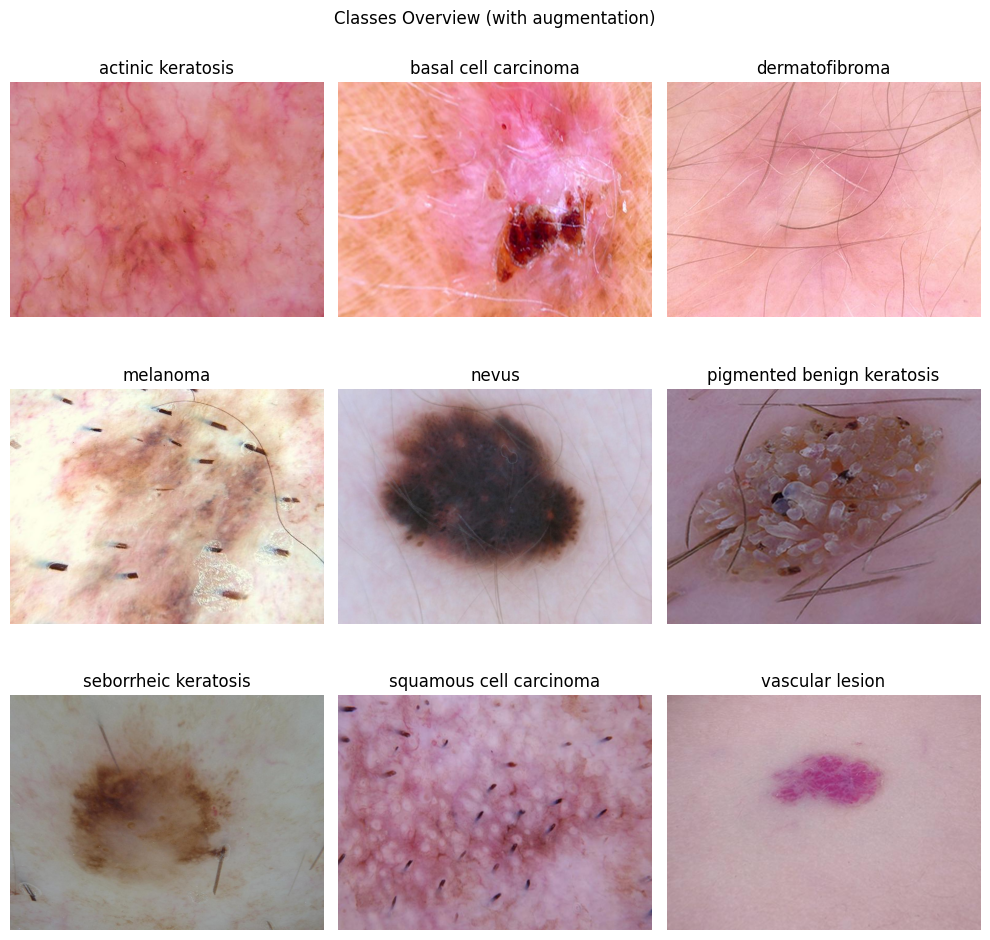

In [18]:
plt.figure(figsize=(10, 10))

for class_index, class_name in enumerate(class_names):
    image_path = list(train_data_dir.glob(class_name + '/output/*.jpg'))[0]
    image = plt.imread(str(image_path))

    plt.subplot(3, 3, class_index + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")

plt.suptitle('Classes Overview (with augmentation)')
plt.tight_layout()
plt.show()

#### 5.3. Dataset Creation

In [19]:
train_ds, val_ds = keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Using 1347 files for validation.


In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#### 5.4. Model Creation

In [21]:
model_2 = keras.Sequential()

# Rescaling layer for rescaling the pixel values range to be in (0, 1)
model_2.add(keras.layers.Rescaling(scale=1./255, input_shape=(180, 180, 3)))

# First convolution layer with 64 features, 3x3 filter, relu activation with 2x2 pooling and batch normalization
model_2.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_2.add(keras.layers.MaxPooling2D())
model_2.add(keras.layers.BatchNormalization())

# Second convolution layer with 64 features, 3x3 filter, relu activation with 2x2 pooling and batch normalization
model_2.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_2.add(keras.layers.MaxPooling2D())
model_2.add(keras.layers.BatchNormalization())

# Third convolution layer with 128 features, 3x3 filter, relu activation with 2x2 pooling and 25% dropout
model_2.add(keras.layers.Conv2D(
    128, (3, 3), padding='same', activation='relu'))
model_2.add(keras.layers.MaxPooling2D())
model_1.add(keras.layers.Dropout(0.25))

# Fourth convolution layer with 128 features, 3x3 filter, relu activation with 2x2 pooling and 25% dropout
model_2.add(keras.layers.Conv2D(
    128, (3, 3), padding='same', activation='relu'))
model_2.add(keras.layers.MaxPooling2D())
model_1.add(keras.layers.Dropout(0.25))

# Final dense layer with relu and softmax activation and 50% dropout
model_2.add(keras.layers.Flatten())
model_2.add(keras.layers.Dense(256, activation='relu'))
model_2.add(keras.layers.Dropout(0.5))
model_2.add(keras.layers.Dense(9, activation='softmax'))

#### 5.5. Model Compiling

In [22]:
model_2.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 90, 90, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 45, 45, 64)       

#### 5.6. Model Training

In [23]:
history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
169/169 [==============================] - 116s 634ms/step - loss: 1.7873 - accuracy: 0.3353 - val_loss: 2.3082 - val_accuracy: 0.1151
Epoch 2/20
169/169 [==============================] - 107s 632ms/step - loss: 1.5010 - accuracy: 0.4316 - val_loss: 2.2628 - val_accuracy: 0.1359
Epoch 3/20
169/169 [==============================] - 109s 643ms/step - loss: 1.4310 - accuracy: 0.4592 - val_loss: 1.7510 - val_accuracy: 0.3638
Epoch 4/20
169/169 [==============================] - 109s 641ms/step - loss: 1.3351 - accuracy: 0.4870 - val_loss: 1.3826 - val_accuracy: 0.4885
Epoch 5/20
169/169 [==============================] - 108s 638ms/step - loss: 1.2815 - accuracy: 0.5189 - val_loss: 1.4005 - val_accuracy: 0.4736
Epoch 6/20
169/169 [==============================] - 107s 634ms/step - loss: 1.2020 - accuracy: 0.5464 - val_loss: 1.2501 - val_accuracy: 0.5316
Epoch 7/20
169/169 [==============================] - 110s 650ms/step - loss: 1.1384 - accuracy: 0.5701 - val_loss: 1.1767 -

#### 5.7. Results

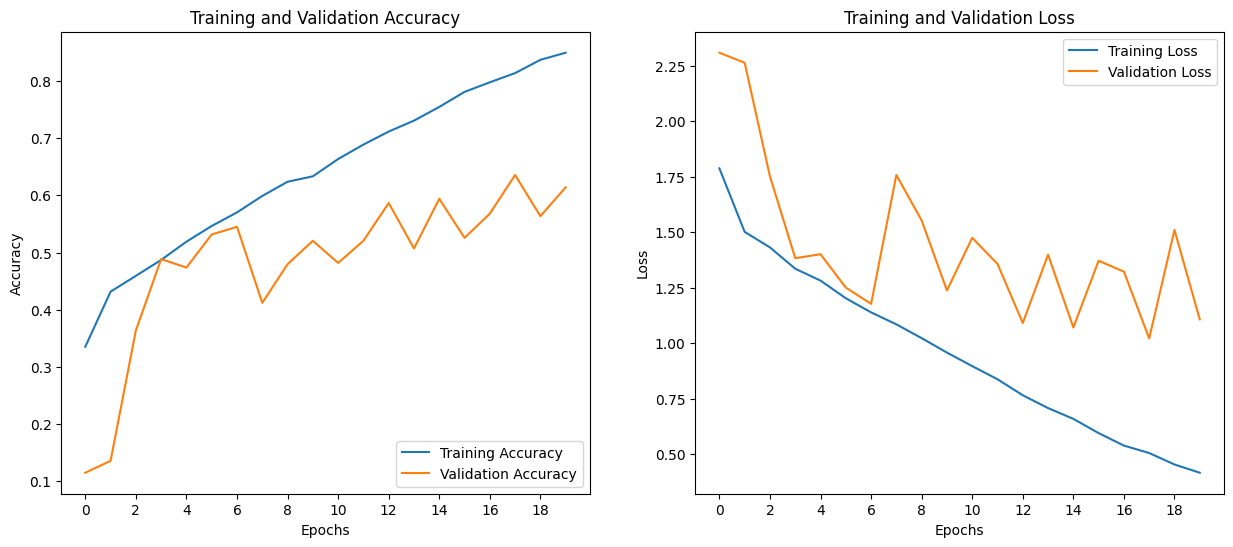

In [24]:
plot_train_val(history_2.history, 20)

The model is now overfitting, this could be due to class imbalance. 

### 6. Class Distribution

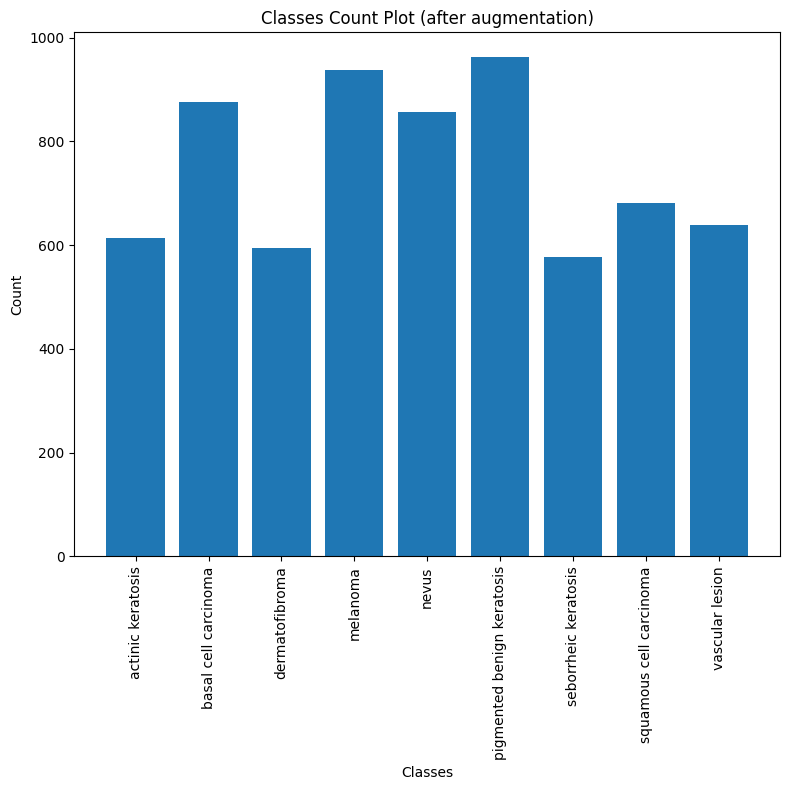

In [25]:
class_count = []

for i in class_names:
    class_count.append(len(list(train_data_dir.glob(i+'/**/*.jpg'))))

plt.figure(figsize=(8, 8))
plt.bar(class_names, class_count)

plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Classes Count Plot (after augmentation)")

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 7. Handling Class Imbalances

Let us balance to have 1000 samples of each class, and delete the previously augmented samples. 

In [26]:
for root, dirs, files in os.walk(train_data_dir):
    for dir_name in dirs:
        if dir_name == "output":
            dir_path = os.path.join(root, dir_name)
            shutil.rmtree(dir_path)
            print(f"Deleted: {dir_path}")

Deleted: Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output
Deleted: Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output
Deleted: Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output
Deleted: Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output
Deleted: Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output
Deleted: Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output
Deleted: Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output
Deleted: Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output
Deleted: Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output


In [27]:
augment_probability = .75

for class_name in class_names:
    n_samples = len(list(train_data_dir.glob(class_name+'/**/*.jpg')))

    p = Augmentor.Pipeline(os.path.join(train_data_dir, class_name))
    p.set_seed(42)

    p.zoom(probability=augment_probability, min_factor=1.1, max_factor=1.5)
    p.flip_random(probability=augment_probability)
    p.rotate(probability=augment_probability,
                max_left_rotation=10, max_right_rotation=10)
    p.skew(probability=augment_probability, magnitude=.5)
    p.shear(probability=augment_probability,
            max_shear_left=10, max_shear_right=10)
    p.random_distortion(probability=augment_probability,
                        grid_height=5, grid_width=5, magnitude=5)
    
    p.sample(1000-n_samples)

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x104462EC0>: 100%|██████████| 886/886 [00:09<00:00, 94.99 Samples/s] 


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x158117880>: 100%|██████████| 624/624 [00:06<00:00, 101.23 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16A189120>: 100%|██████████| 905/905 [00:08<00:00, 101.36 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16DA73340>: 100%|██████████| 562/562 [00:29<00:00, 19.25 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x169715720>: 100%|██████████| 643/643 [00:32<00:00, 19.67 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x158117B80>: 100%|██████████| 538/538 [00:05<00:00, 98.21 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16DA30C70>: 100%|██████████| 923/923 [00:23<00:00, 38.59 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16A020FA0>: 100%|██████████| 819/819 [00:08<00:00, 98.98 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16A2C0730>: 100%|██████████| 861/861 [00:08<00:00, 97.92 Samples/s]                  


#### 7.1. Class Distribution (after class balancing)

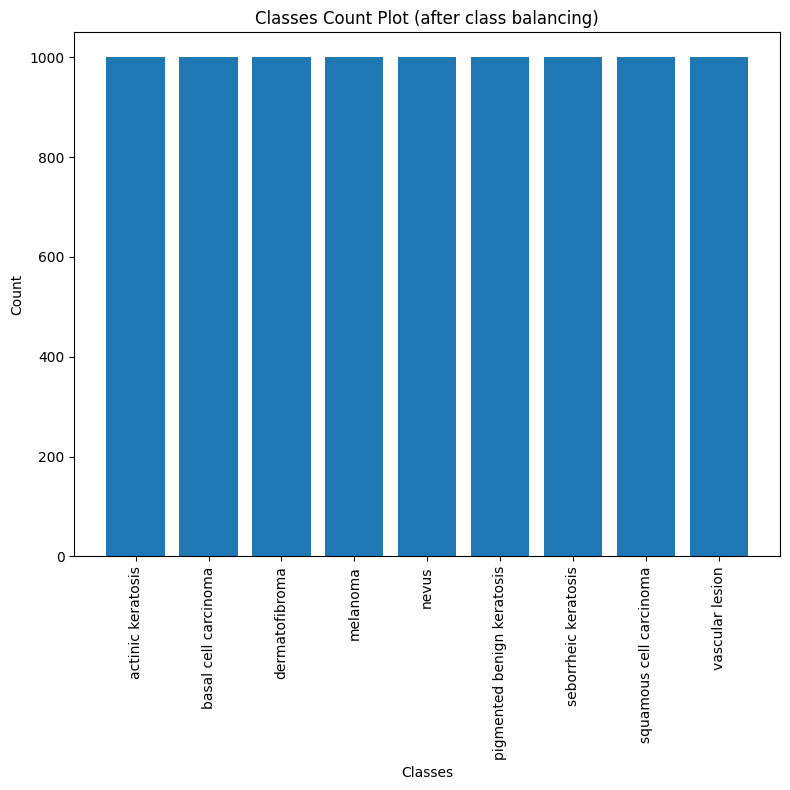

In [28]:
class_count = []

for i in class_names:
    class_count.append(len(list(train_data_dir.glob(i+'/**/*.jpg'))))

plt.figure(figsize=(8, 8))
plt.bar(class_names, class_count)

plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Classes Count Plot (after class balancing)")

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 8. Model Building & Training (on the rectified class imbalance data)

#### 8.1. Dataset Creation

In [29]:
train_ds, val_ds = keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.
Using 1800 files for validation.


In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#### 8.2. Model Creation

In [31]:
model_3 = keras.Sequential()

# Rescaling layer for rescaling the pixel values range to be in (0, 1)
model_3.add(keras.layers.Rescaling(scale=1./255, input_shape=(180, 180, 3)))

# First convolution layer with 64 features, 3x3 filter, relu activation with 2x2 pooling and batch normalization
model_3.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_3.add(keras.layers.MaxPooling2D())
model_3.add(keras.layers.BatchNormalization())

# Second convolution layer with 64 features, 3x3 filter, relu activation with 2x2 pooling and batch normalization
model_3.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model_3.add(keras.layers.MaxPooling2D())
model_3.add(keras.layers.BatchNormalization())

# Third convolution layer with 128 features, 3x3 filter, relu activation with 2x2 pooling and 50% dropout
model_3.add(keras.layers.Conv2D(
    128, (3, 3), padding='same', activation='relu'))
model_3.add(keras.layers.MaxPooling2D())
model_3.add(keras.layers.Dropout(0.25))

# Fourth convolution layer with 128 features, 3x3 filter, relu activation with 2x2 pooling and 50% dropout
model_3.add(keras.layers.Conv2D(
    128, (3, 3), padding='same', activation='relu'))
model_3.add(keras.layers.MaxPooling2D())
model_3.add(keras.layers.Dropout(0.25))

# Final dense layer with relu and softmax activation and 50% dropout
model_3.add(keras.layers.Flatten())
model_3.add(keras.layers.Dense(256, activation='relu'))
model_3.add(keras.layers.Dropout(0.5))
model_3.add(keras.layers.Dense(9, activation='softmax'))

#### 8.3. Model Compiling 

In [32]:
model_3.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 90, 90, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 45, 45, 64)       

#### 8.4. Model Training

In [33]:
history_3 = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20


2023-08-07 09:12:05.629524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 215 of 1000
2023-08-07 09:12:05.753071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


225/225 [==============================] - 153s 631ms/step - loss: 1.8111 - accuracy: 0.3168 - val_loss: 2.2098 - val_accuracy: 0.1356
Epoch 2/20
225/225 [==============================] - 142s 628ms/step - loss: 1.5302 - accuracy: 0.4140 - val_loss: 2.0583 - val_accuracy: 0.2039
Epoch 3/20
225/225 [==============================] - 142s 632ms/step - loss: 1.4261 - accuracy: 0.4521 - val_loss: 1.4736 - val_accuracy: 0.4589
Epoch 4/20
225/225 [==============================] - 142s 629ms/step - loss: 1.3570 - accuracy: 0.4829 - val_loss: 1.5556 - val_accuracy: 0.4117
Epoch 5/20
225/225 [==============================] - 143s 637ms/step - loss: 1.3116 - accuracy: 0.5022 - val_loss: 1.5588 - val_accuracy: 0.4039
Epoch 6/20
225/225 [==============================] - 143s 635ms/step - loss: 1.2434 - accuracy: 0.5300 - val_loss: 1.4798 - val_accuracy: 0.4372
Epoch 7/20
225/225 [==============================] - 150s 668ms/step - loss: 1.1951 - accuracy: 0.5435 - val_loss: 1.5168 - val_accura

#### 8.5. Results

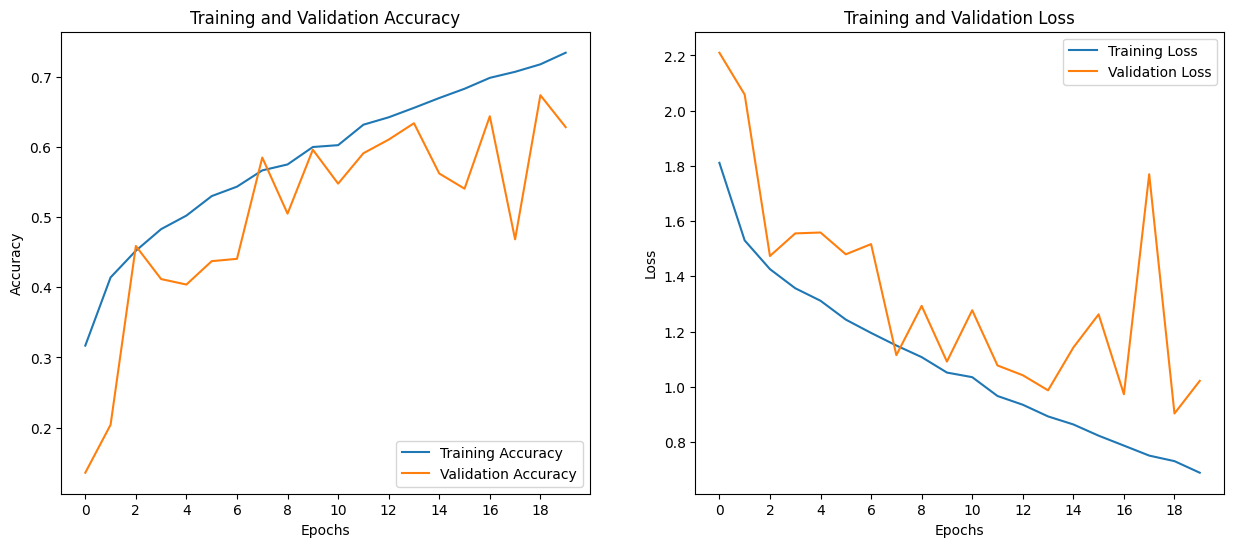

In [34]:
plot_train_val(history_3.history, 20)

This seems to be a bit underfitting again.

## Conclusion

In [35]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.


In [36]:
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
test_loss, test_accuracy = model_3.evaluate(test_ds)

4/4 [==============================] - 3s 149ms/step - loss: 2.4500 - accuracy: 0.4322


We can see that even after augmentation and having balanced classes, and the plots also suggest a decent model, yet we have very less accuracy on the test data. 

By adding a lot more samples maybe we can expect a good model.